In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [3]:
batch_size = 4
transform = transforms.Compose(
    [transforms.ToTensor()])
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda")
cfg = {
    'VGG7': [64, 'M', 128, 'M', 256, "M",512,"M"],
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class Net(nn.Module):
    def __init__(self, vgg_name):
        super(Net, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
net = Net("VGG11").to(device)

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(6):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

            

net.eval()
print('Finished Training')

KeyboardInterrupt: 

In [28]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 80 %


In [8]:
def compute_data_grad(model, image, target, device):

    # Set requires_grad attribute of tensor. Important for Attack

    # Forward pass the data through the model
    
    image.requires_grad_()

    output = model(image)
    # Calculate the loss
    loss = F.nll_loss(output, target)

    # Zero all existing gradients
    #model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = image.grad.data
    return data_grad


def pgd_attack(image, target,  model, device, epsilon = 8/255, eta = 2/255, nmax = 10):
    x_k = image
    for i in range(nmax):
        tmp = x_k.clone()
        tmp.requires_grad_()

        output = model(tmp)
        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = tmp.grad.data
        #data_grad = compute_data_grad(model, x_k, target, device)
        y_k = x_k + eta * data_grad.sign()
        x_k = torch.clamp(y_k, image - epsilon, image + epsilon)
        x_k = torch.clamp(x_k, 0, 1)
    return x_k


def test(model, test_loader, device, epsilon = 8/255):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        
        
        data, target = data.to(device), target.to(device)
        
        # Call FGSM Attack
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] 
        perturbed_data = pgd_attack(data,target, model, device)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples



#net = net.to(device)
#test(net, testloader, device, epsilon = 0.031)

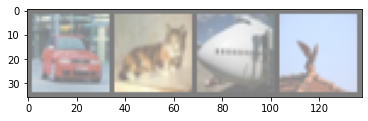

car   cat   plane bird 


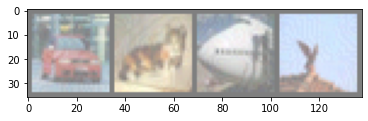

['deer', 'car', 'horse', 'deer']


In [46]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image



def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


images = images.to(device)
labels= labels.to(device)
perturbed = pgd_attack(images,labels, net, device)
cpu = torch.device("cpu")


predicted =  net(perturbed)
perturbed = perturbed.to(cpu)
images = images.to(cpu)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
imshow(torchvision.utils.make_grid(perturbed))
final_pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
print([classes[i] for i in final_pred])

In [31]:
import pickle
with open("model_naif.pkl","wb") as f:
    pickle.dump(net, f)

# Resistant to adversial attacks

In [17]:
def pgd_delta(image, target,  model, device, epsilon = 8/255, eta = 2/255, nmax = 10):
    x_k = image
    for i in range(nmax):
        tmp = x_k.clone()
        tmp.requires_grad_()

        output = model(tmp)
        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = tmp.grad.data
        #data_grad = compute_data_grad(model, x_k, target, device)
        y_k = x_k + eta * data_grad.sign()
        x_k = torch.clamp(y_k, image - epsilon, image + epsilon)
    return x_k - image


for epoch in range(27, 40):  # loop over the dataset multiple times
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        delta = pgd_delta(inputs, labels, net, device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs + delta)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
    with open("model_tank"+str(epoch)+"."+str(int(running_loss))+".pkl","wb") as f:
        pickle.dump(net, f)
            

net.eval()
print('Finished Training')

[28,   200] loss: 0.680
[28,   400] loss: 0.713
[28,   600] loss: 0.666
[28,   800] loss: 0.704
[28,  1000] loss: 0.696
[28,  1200] loss: 0.654
[28,  1400] loss: 0.719
[28,  1600] loss: 0.665
[28,  1800] loss: 0.701
[28,  2000] loss: 0.684
[28,  2200] loss: 0.716
[28,  2400] loss: 0.668
[28,  2600] loss: 0.718
[28,  2800] loss: 0.731
[28,  3000] loss: 0.689
[28,  3200] loss: 0.723
[28,  3400] loss: 0.687
[28,  3600] loss: 0.673
[28,  3800] loss: 0.701
[28,  4000] loss: 0.721
[28,  4200] loss: 0.690
[28,  4400] loss: 0.679
[28,  4600] loss: 0.701
[28,  4800] loss: 0.720
[28,  5000] loss: 0.683
[28,  5200] loss: 0.691
[28,  5400] loss: 0.672
[28,  5600] loss: 0.728
[28,  5800] loss: 0.649
[28,  6000] loss: 0.697
[28,  6200] loss: 0.668
[28,  6400] loss: 0.679
[28,  6600] loss: 0.717
[28,  6800] loss: 0.738
[28,  7000] loss: 0.679
[28,  7200] loss: 0.741
[28,  7400] loss: 0.677
[28,  7600] loss: 0.625
[28,  7800] loss: 0.752
[28,  8000] loss: 0.651
[28,  8200] loss: 0.682
[28,  8400] loss

In [15]:

net.eval()
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 67 %


In [9]:
test(net1, testloader, device, epsilon = 0.031)

Epsilon: 0.031	Test Accuracy = 2696 / 10000 = 0.2696


(0.2696,
 [(5, 5, array([[[0.5882353 , 0.5921569 , 0.6156863 , ..., 0.5372549 ,
            0.4784314 , 0.4862745 ],
           [0.5647059 , 0.56078434, 0.5921569 , ..., 0.5019608 ,
            0.45882353, 0.4509804 ],
           [0.56078434, 0.56078434, 0.5882353 , ..., 0.54509807,
            0.5411765 , 0.5019608 ],
           ...,
           [0.2509804 , 0.19607843, 0.15294118, ..., 0.18039216,
            0.08235294, 0.1882353 ],
           [0.2627451 , 0.22352941, 0.16862746, ..., 0.13333334,
            0.14509805, 0.10980393],
           [0.24313726, 0.2509804 , 0.20784314, ..., 0.1254902 ,
            0.16470589, 0.1137255 ]],
   
          [[0.40784314, 0.40392157, 0.42352942, ..., 0.35686275,
            0.37254903, 0.3647059 ],
           [0.47058824, 0.44705883, 0.41568628, ..., 0.34117648,
            0.3254902 , 0.36078432],
           [0.4       , 0.39607844, 0.43529412, ..., 0.41568628,
            0.40392157, 0.38039216],
           ...,
           [0.45490196, 0.4235

In [13]:
import pickle
with open("model_tank.pkl","wb") as f:
    pickle.dump(net, f)

In [5]:
import pickle
with open("model_tank39.76.pkl","rb") as f:
    net1 = pickle.load( f)

In [ ]:
i, epoch